# EDA

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

In [3]:
import warnings

# 경고 무시하기
warnings.filterwarnings("ignore")
# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

In [4]:
df = pd.read_csv('./통합데이터/강남구전세데이터_찐마지막.csv', encoding='utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87361 entries, 0 to 87360
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AD_Code         87361 non-null  int64  
 1   Admin_District  87361 non-null  object 
 2   Area            87361 non-null  float64
 3   YearBuilt       87361 non-null  int64  
 4   Type            87361 non-null  object 
 5   Floor           87361 non-null  float64
 6   Address         87361 non-null  object 
 7   Cont_Date       87361 non-null  object 
 8   Age             87361 non-null  int64  
 9   Latitude        87361 non-null  float64
 10  Longitude       87361 non-null  float64
 11  Star_Cnt        87361 non-null  int64  
 12  Michelin_Cnt    87361 non-null  int64  
 13  Mc_cnt          87361 non-null  int64  
 14  Bigstore_cnt    87361 non-null  int64  
 15  InterestRate    87361 non-null  float64
 16  Market_cnt      87361 non-null  int64  
 17  Subway_cnt      87361 non-null 

## 가장 중요한 변수 탐색

### 타겟 변수

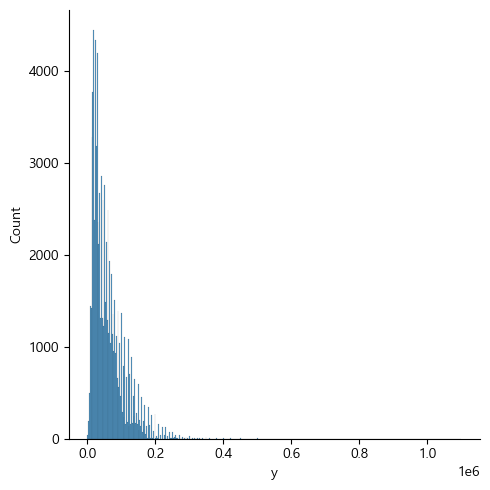

In [4]:
sns.displot(df, x="y")

# 가격이 왜곡되어있다.
# 비교적 저렴한 가격이 거래량이 많은 것은 예상가능한 결과이다.

## 타겟과의 상관관계를 알아보자

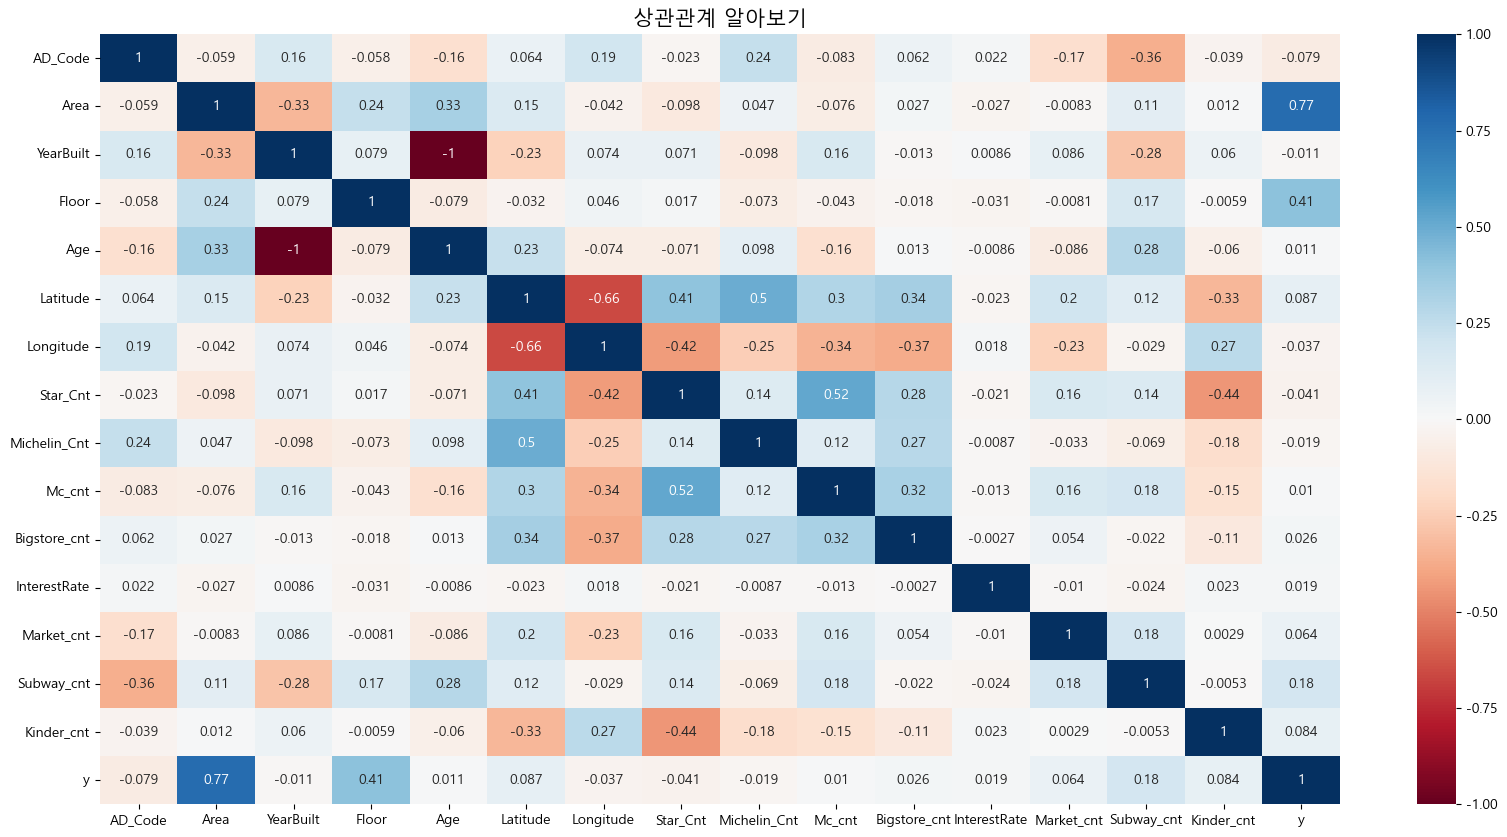

In [5]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), cmap="RdBu", annot=True)
plt.title("상관관계 알아보기", size=15)
plt.show()

# 캐글에서는 다중공선성도 고려하였다.
# 높은 상관관계를 갖는 피처변수들은 예측에 악영향

## 타겟과 높은 상관관계를 갖는 피처변수에 대해 시각화

### Area (상관관계가 가장 높다)

- 면적이 넓을수록 비싼 것은 예상가능한 결과이다.

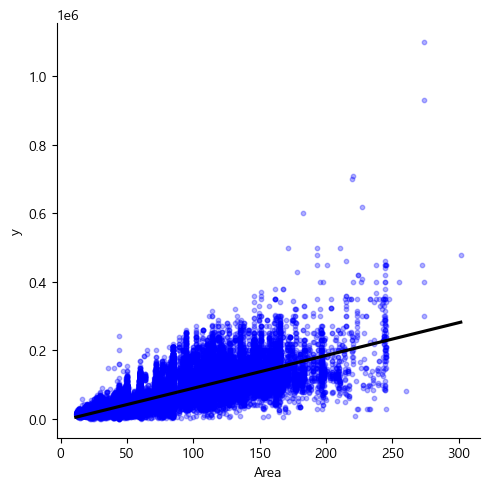

In [37]:
sns.lmplot(x="Area", y="y", data=df, scatter_kws={"s": 10, 'color':'blue', 'alpha':0.3},
          line_kws={'color':'black'});

# 면적이 높으면서 전세금이 매우 높은 주택 2곳은 확실히 이상치로 보인다.

## Floor (상관관계가 두 번째로 높다.)

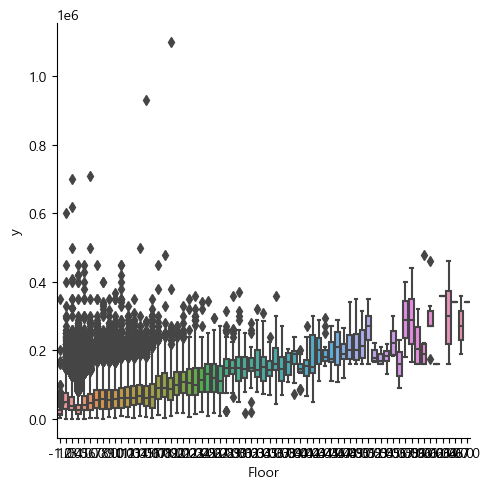

In [6]:
sns.catplot(data=df, x="Floor", y="y", kind="box")

# 전체적으로 약한 양의 상관관계를 보인다.
# 제거해야하는 이상치가 보인다.

## Floor를 구간으로 나눠서 확인해보자

In [7]:
# Define the bin edges
bins = [-float('inf'), 3, 5, 10, float('inf')]
bin_labels = ['0-3', '3-5', '5-10', '10-67']

# Create a new column 'band' that contains the bin labels
df['Floor_band'] = pd.cut(df['Floor'], bins=bins, labels=bin_labels, right=False)

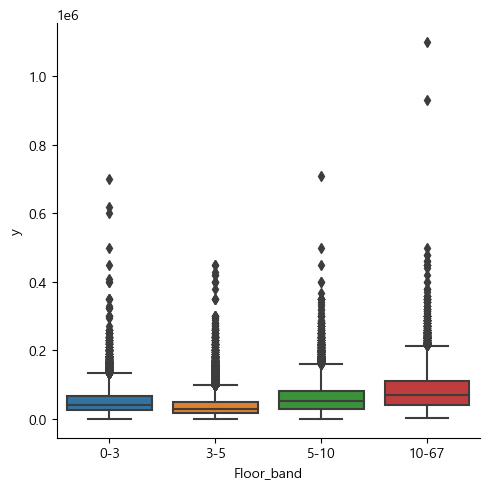

In [8]:
sns.catplot(data=df, x="Floor_band", y="y", kind="box")

# 선형관계가 좀 더 약해져 보인다.

In [24]:
#### 범위를 좀 더 세밀하게 나눠보자.
#### 범주에 들어가는 개수가 비슷해지도록 구간을 나눠보았다.


# Define the bin edges
bins = [-float('inf'), 3, 4, 5, 7, 10, float('inf')]
bin_labels = ['0-3', '3-4', '4-5', '5-7','7-10', '10-67']

# Create a new column 'band' that contains the bin labels
df['Floor_band'] = pd.cut(df['Floor'], bins=bins, labels=bin_labels, right=False)

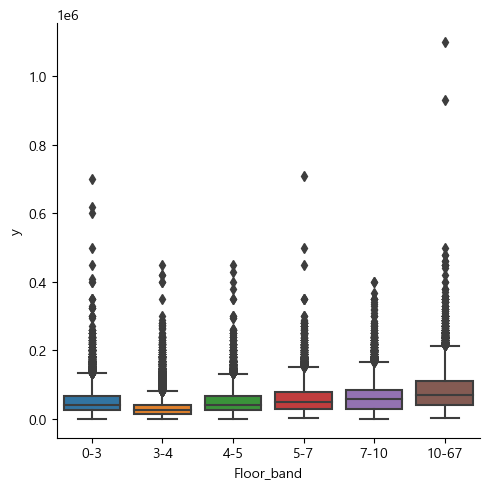

In [25]:
sns.catplot(data=df, x="Floor_band", y="y", kind="box")

##### 매우 약한 선형관계가 보인다.

In [26]:
df['Floor_band'].value_counts().sort_index()

0-3      14274
3-4      18567
4-5       7995
5-7      11693
7-10     12537
10-67    22295
Name: Floor_band, dtype: int64

### 스세권? 맥세권?

- 상관관계로 봐서는 스세권 맥세권은 영향이 없어보인다.
- 휴게음식점 변수로 묶어서 분석해보자

In [45]:
df['휴게음식점'] = df['Michelin_Cnt'] + df['Mc_cnt']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87361 entries, 0 to 87360
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   AD_Code         87361 non-null  int64   
 1   Admin_District  87361 non-null  object  
 2   Area            87361 non-null  float64 
 3   YearBuilt       87361 non-null  int64   
 4   Type            87361 non-null  object  
 5   Floor           87361 non-null  float64 
 6   Address         87361 non-null  object  
 7   Cont_Date       87361 non-null  object  
 8   Age             87361 non-null  int64   
 9   Latitude        87361 non-null  float64 
 10  Longitude       87361 non-null  float64 
 11  Star_Cnt        87361 non-null  int64   
 12  Michelin_Cnt    87361 non-null  int64   
 13  Mc_cnt          87361 non-null  int64   
 14  Bigstore_cnt    87361 non-null  int64   
 15  InterestRate    87361 non-null  float64 
 16  Market_cnt      87361 non-null  int64   
 17  Subway_cnt  

In [46]:
df['휴게음식점'].corr(df['y'])

# -0.034159212067319075 스 + 미 + 맥
# -0.03715849079417894 스 + 미
# -0.034348799587544325 스 + 맥
# -0.016785162849956688 미 + 맥

-0.016785162849956688

- 스타벅스와 맥날은 가까운 곳으로 갈텐데
- 집 주변 반경에서의 개수보다 최소거리로 사용해보자

### 역세권?

- 역세권은 상관관계가 클 것으로 예상했는데 결과는 그렇지 않다
- 가장 가까운 역까지의 거리를 사용해보자!

In [49]:
df_subway = pd.read_csv('./main/강남구전세루트데이터+역세권.csv', encoding='utf-8')

In [73]:
def min_subway(series):
    return series.median()
    
  

df_groupby = df_subway.groupby(['index','도로명주소'])['Distance_to_station'].agg(min_subway)

In [74]:
df_groupby = df_groupby.reset_index(drop=True)
df_groupby.name = 'median'

In [75]:
df = pd.concat([df, df_groupby], axis=1)
df

,AD_Code,Admin_District,Area,YearBuilt,Type,Floor,Address,Cont_Date,Age,Latitude,...,Market_cnt,Subway_cnt,Kinder_cnt,y,Floor_band,휴게음식점,Distance_to_station,Distance_to_station,mean,median
0,0,개포동,44.00,1989,단독다가구,3.0,서울특별시 강남구 논현로4길,2022-06-01,34,37.473722,...,0,0,2,7500,3-4,0,1.55,3.771111,3.771111,4.01
1,0,개포동,44.00,1991,단독다가구,3.0,서울특별시 강남구 논현로4길,2022-10-05,32,37.473722,...,0,0,2,14333,3-4,0,1.55,3.771111,3.771111,4.01
2,0,개포동,44.00,1991,단독다가구,3.0,서울특별시 강남구 논현로4길,2022-07-07,32,37.473722,...,0,0,2,17115,3-4,0,1.55,3.771111,3.771111,4.01
3,0,개포동,44.00,1991,단독다가구,3.0,서울특별시 강남구 논현로4길,2022-07-07,32,37.473722,...,0,0,2,17640,3-4,0,1.55,3.771111,3.771111,4.01
4,0,개포동,44.00,1989,단독다가구,3.0,서울특별시 강남구 논현로4길,2022-06-01,34,37.473722,...,0,0,2,7500,3-4,0,1.55,3.771111,3.771111,4.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87356,2,대치동,66.64,2004,오피스텔,8.0,서울특별시 강남구 역삼로 432,2019-07-22,19,37.501439,...,0,0,1,45000,7-10,2,0.59,2.069259,2.069259,1.92
87357,13,청담동,43.68,2005,오피스텔,5.0,서울특별시 강남구 압구정로 461,2019-06-21,18,37.525283,...,0,0,1,38000,5-7,17,0.64,3.006667,3.006667,2.90
87358,13,청담동,31.57,2014,오피스텔,5.0,서울특별시 강남구 도산대로 406,2019-07-20,9,37.522821,...,0,0,0,23500,5-7,32,0.51,2.872222,2.872222,2.48
87359,0,개포동,29.51,2020,오피스텔,6.0,서울특별시 강남구 논현로20길 12,2020-09-08,3,37.478097,...,0,0,1,3000,5-7,0,0.99,3.427778,3.427778,3.46


In [76]:
df['y'].corr(df['median'])

# -0.14891677826040692 min
# -0.1433202357673193 mean
# -0.1309430759565135 median

-0.1309430759565135

## 대규모 점포와 시장도 합쳐보자

In [80]:
df['대규모점포'] = df['Bigstore_cnt'] + df['Market_cnt']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87361 entries, 0 to 87360
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   AD_Code              87361 non-null  int64   
 1   Admin_District       87361 non-null  object  
 2   Area                 87361 non-null  float64 
 3   YearBuilt            87361 non-null  int64   
 4   Type                 87361 non-null  object  
 5   Floor                87361 non-null  float64 
 6   Address              87361 non-null  object  
 7   Cont_Date            87361 non-null  object  
 8   Age                  87361 non-null  int64   
 9   Latitude             87361 non-null  float64 
 10  Longitude            87361 non-null  float64 
 11  Star_Cnt             87361 non-null  int64   
 12  Michelin_Cnt         87361 non-null  int64   
 13  Mc_cnt               87361 non-null  int64   
 14  Bigstore_cnt         87361 non-null  int64   
 15  InterestRate       

In [81]:
df['y'].corr(df['대규모점포'])

0.04718508549639521

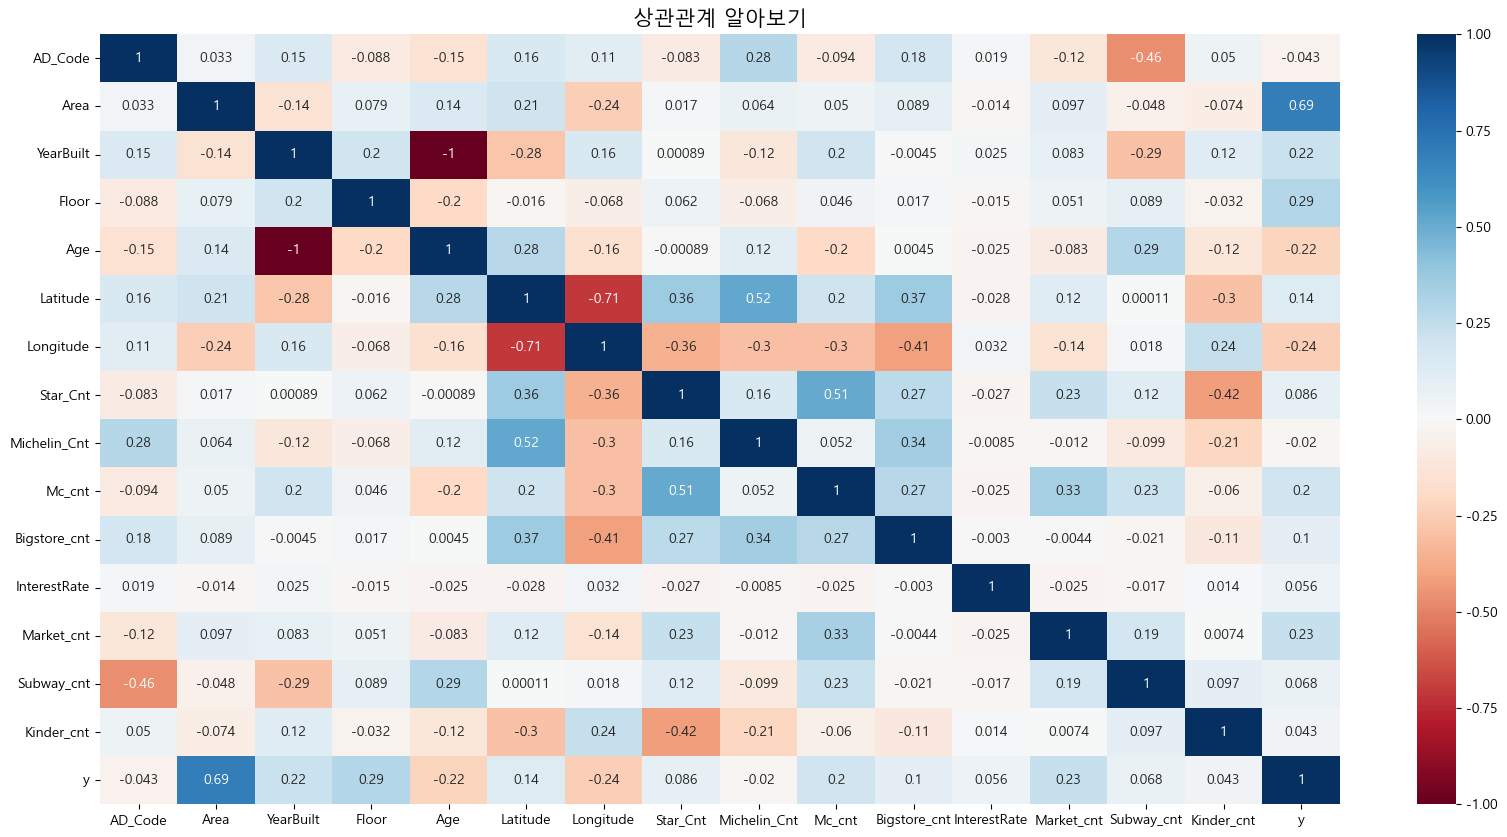

In [7]:
plt.figure(figsize=(20,10))
sns.heatmap(df[df['Type']=='아파트'].corr(), cmap="RdBu", annot=True)
plt.title("상관관계 알아보기", size=15)
plt.show()